## DataLoader class and data loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from jetnet.datasets import JetNet
from jetnet.utils import to_image
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class DataLoader:
  def __init__(self):
    pass

  def get_data(num_images=70000, Raggio = 0.4, LAST=False, SAVE = False):
    ''' DOWNLOAD DATA '''
    #set args to load the data
    data_args = {
        "jet_type": ["g", "q", "t", "w", "z"],
        # ‘g’ (gluon), ‘q’ (light quarks), ‘t’ (top quarks), ‘w’ (W bosons), or ‘z’ (Z bosons)
        "data_dir": "datasets/jetnet",
        # only selecting the kinematic features
        "particle_features": ["etarel", "phirel", "ptrel"],
        "num_particles": 30,
        "jet_features": ["type"],
        "download": False,
        "split": "all",
    }

    # download as numpy arrays
    particle_data, jet_data = JetNet.getData(**data_args)

    ''' TRANSFORM TO IMAGES '''
    im_size = 50 #pixel size of the length of the image
    maxR=Raggio #maximum radius of the jet
    if LAST == True:
      X_train = np.array( [to_image(particle_data[len(particle_data) - num_images + i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[-num_images:]
    else:
      X_train = np.array( [to_image(particle_data[i], im_size, maxR=maxR) for i in range(num_images)] )
      Y_train = jet_data[:num_images]

    if SAVE and LAST:
      np.savez("X_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_test_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)
    elif SAVE:
      np.savez("X_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", X_train)
      np.savez("Y_N" + str(num_images) + "_lpx" + str(im_size) + "_gqtwz", Y_train)

    return X_train, Y_train

  def get_data_onehot(train=42000, valid=14000, test=14000, Raggio= 0.4, SAVE = False):
    X_Data, Y_Data = DataLoader.get_data(train+valid, Raggio=Raggio, SAVE = SAVE)
    # data split

    X_train, X_val = X_Data[:train], X_Data[train:]
    Y_train, Y_val = Y_Data[:train], Y_Data[train:]

    X_test, Y_test = DataLoader.get_data(test, Raggio=Raggio, LAST=True, SAVE = SAVE)

    # one hot encoding the lables
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_train_onehot = one_hot_encoder.fit_transform(Y_train.reshape((-1,1)))
    Y_valid_onehot = one_hot_encoder.fit_transform(Y_val.reshape((-1,1)))
    Y_test_onehot = one_hot_encoder.fit_transform(Y_test.reshape((-1,1)))

    return X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot

In [4]:
# test
X_train, X_val, X_test, Y_train_onehot, Y_valid_onehot, Y_test_onehot = DataLoader.get_data_onehot(train=200000, valid=50000, test=50000, Raggio = 0.1)

## Model eval class

In [ ]:
plt.rcParams.update({
    "font.family": "FreeSerif",
    "axes.labelsize": 15,
    "font.size": 15,
    "legend.fontsize": 10,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
})

class ModelEval:
  def __init__(self, model, X_test_set, Y_test_set, model_str="model", cmap='inferno'):
    self.X_test = X_test_set
    self.Y_test = Y_test_set
    self.cmap = cmap
    self.model_str = model_str
    self.model = model
    self.array_labels = ["gluon", "light\nquarks", "top\nquark", "W boson", "Z boson"]

    self.Y_test_pred = self.model.predict(self.X_test)
    self.Y_test_pred_classes = np.argmax(self.Y_test_pred, axis=1)
    self.Y_test_classes = np.argmax(self.Y_test, axis=1)

  def Conf_Matrix_and_ROC_curve(self):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.3)

    ''' Confusion Matrix '''
    from sklearn.metrics import confusion_matrix

    conf_m = confusion_matrix(self.Y_test_classes, self.Y_test_pred_classes)
    print("Confusion matrix of " + self.model_str)

    mappable = ax[0].matshow(conf_m, cmap=self.cmap)
    ax[0].set_title("Confusion matrix of " + self.model_str, pad=20)
    ax[0].set_xlabel("Predicted class", labelpad=10)
    ax[0].set_ylabel("True class")
    ax[0].set_xticks(range(5), self.array_labels)
    ax[0].set_yticks(range(5), self.array_labels)
    ax[0].set_aspect('equal')
    fig.colorbar(mappable=mappable, ax=ax[0], shrink=0.85)
    ax[0].xaxis.set_ticks_position("bottom")

    # Add text annotations for each element
    for i in range(conf_m.shape[0]):
        for j in range(conf_m.shape[1]):
            text = ax[0].text(j, i, conf_m[i, j], ha="center", va="center", color="green")

    ''' ROC Curve '''
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    for i in range(5):
      fpr, tpr, thresholds = roc_curve(self.Y_test[:,i], self.Y_test_pred[:, i])
      ax[1].plot(fpr, tpr, linewidth=2, label='{0} (area = {1:0.2f})'.format(self.array_labels[i], round(roc_auc_score(self.Y_test[:,i], self.Y_test_pred[:, i]), 5)))

    ax[1].plot([0, 1], [0, 1], 'k--') # dashed diagonal
    ax[1].grid(1)
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend(fontsize=15)
    ax[1].set_aspect('equal')
    plt.show()

  def accuracy_loss(self, hist):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), dpi=200)
    plt.subplots_adjust(wspace=0.2)

    ax[0].plot(hist['accuracy'], "--", label='Train Accuracy', color="deepskyblue")
    ax[0].plot(hist['val_accuracy'], ".-", label='Validation Accuracy', color="orange")
    ax[0].set_title("Accuracy " + self.model_str, pad=20)
    ax[0].set_xlabel("Epoch", labelpad=10)
    ax[0].legend(fontsize=15)

    ax[1].plot(hist['loss'], "--", label='Train Loss Function', color="deepskyblue")
    ax[1].plot(hist['val_loss'], ".-", label='Validation Loss Function', color="orange")
    ax[1].set_title("Loss function " + self.model_str, pad=20)
    ax[1].set_xlabel("Epoch", labelpad=10)
    ax[1].legend(fontsize=15)
    plt.show()

## Fully Connected NN

In [ ]:
import pandas as pd
import tensorflow as tf

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = [50,50]),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(2500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(2000, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1800, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
model0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2500)           │     6,252,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2500)           │        10,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2000)           │     5,002,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2000)           │         8,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1800)           │     3,601,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1800)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1800)           │         7,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1500)           │     2,701,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1500)           │         6,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1500)           │     2,251,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1500)           │         6,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 800)            │     1,200,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 800)            │         3,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       160,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200)            │           80

 Total params: 21,243,005 (81.04 MB)

 Trainable params: 21,222,105 (80.96 MB)

 Non-trainable params: 20,900 (81.64 KB)

In [ ]:
model1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = ['accuracy'],
)


history = model1.fit(
    X_train, Y_train_onehot,
    batch_size = 256,
    epochs = 4,
    validation_data = (X_val, Y_valid_onehot),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.4415 - loss: 1.3683 - val_accuracy: 0.5136 - val_loss: 1.1896
Epoch 2/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5264 - loss: 1.1662 - val_accuracy: 0.5457 - val_loss: 1.1283
Epoch 3/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5535 - loss: 1.1106 - val_accuracy: 0.5645 - val_loss: 1.0961
Epoch 4/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5809 - loss: 1.0619 - val_accuracy: 0.5787 - val_loss: 1.0799


## Fully Connected NN - results

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step


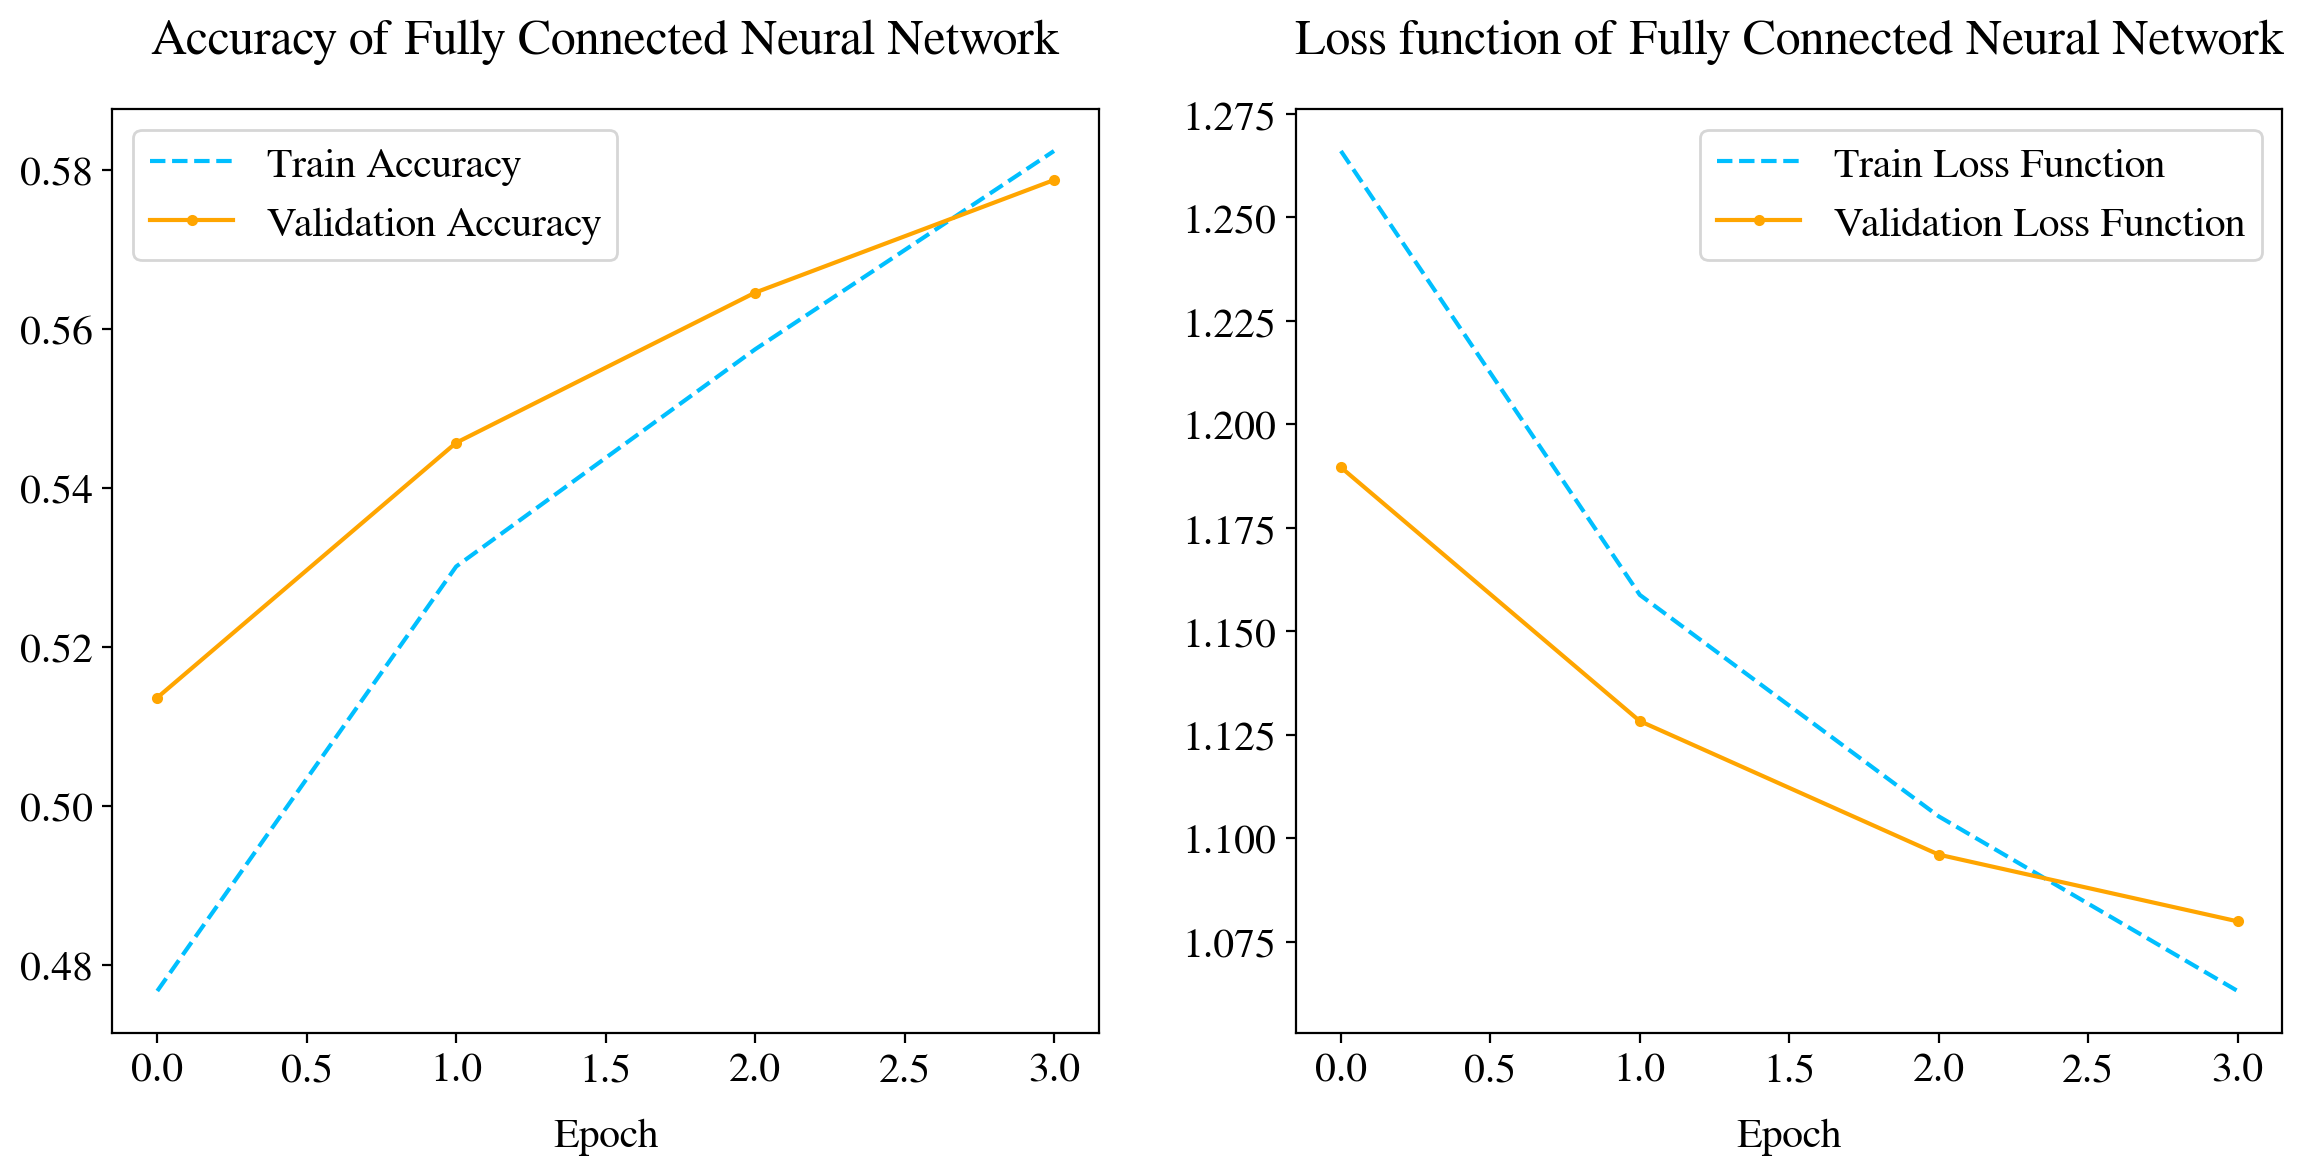

In [ ]:
#class instantiation
m = ModelEval(model1, X_test, Y_test_onehot, model_str="Fully Connected Neural Network")

#methods calling
m.accuracy_loss(pd.DataFrame(history.history))

In [ ]:
model1.evaluate(X_test, Y_test_onehot)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5777 - loss: 1.0844


[1.08505380153656, 0.5796200037002563]

Confusion matrix of Fully Connected Neural Network


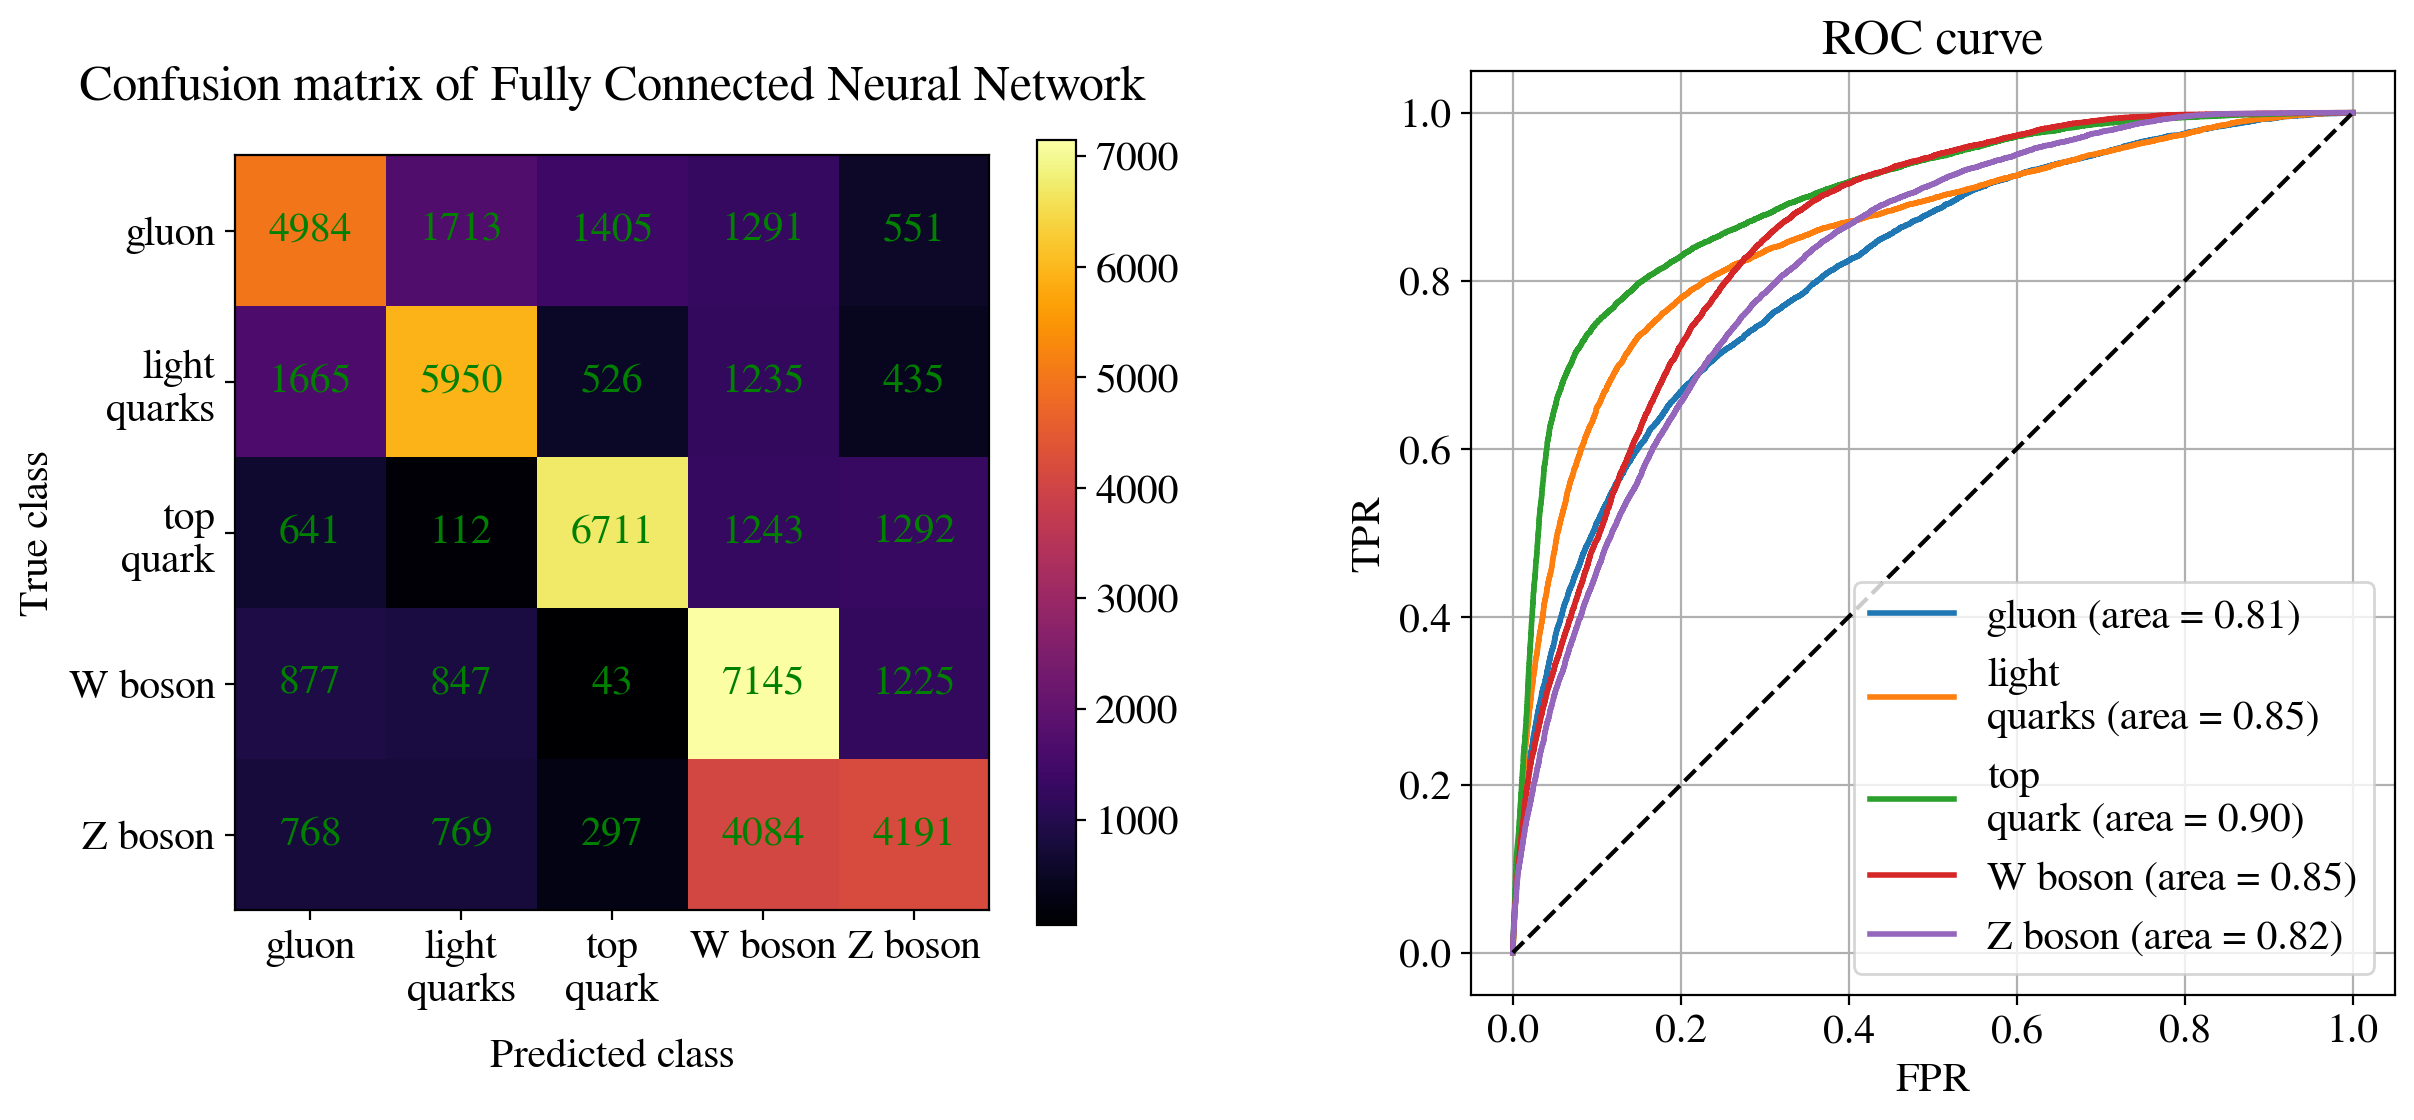

In [ ]:
m.Conf_Matrix_and_ROC_curve()